---
title: Homework 3
author: Jichao Yang
format: 
    pdf:
        documentclass: article
        papersize: letter
        geometry:
            - top = 1in
            - bottom = 1in
            - left = 1in
            - right = 1in
---

# Problem 1

(a) Both `WBscore` and `PCCsymp` are categorical ordinal variables.

In [137]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

test = pd.read_csv('../../data/PCC_study_test.csv', index_col=0)
train = pd.read_csv('../../data/PCC_study_train.csv', index_col=0)

# Convert vaccination status variable to boolean
test['vax_status'] = (test['vax_status']=='Vaccinated').astype('float')
train['vax_status'] = (train['vax_status']=='Vaccinated').astype('float')

# Check variable types
print('Values for WBscore are {}'.format(np.unique(train['WBscore'])))
print('Values for PCCsymp are {}'.format(np.unique(train['PCCsymp'])))

Values for WBscore are ['Improved' 'Unchanged' 'Worsened']
Values for PCCsymp are ['Less' 'More' 'Same']


\pagebreak \
(b) Both categorical variables are significant. Specifically, the factors where `WBscore` is `Improved` and `PCCsymp` is `Less` are significant.

In [138]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Create dummies for categorical variables
y_train = train[['vax_status']]
y_test = test[['vax_status']]

x_train = pd.get_dummies(train[['WBscore', 'PCCsymp']], dtype='float')
x_train = sm.add_constant(x_train)
x_test = pd.get_dummies(test[['WBscore', 'PCCsymp']], dtype='float')
x_test = sm.add_constant(x_test)

# Drop one dummy for each variable to prevent colinearity
x_train = x_train.drop(['WBscore_Unchanged', 'PCCsymp_Same'], axis=1)
x_test = x_test.drop(['WBscore_Unchanged', 'PCCsymp_Same'], axis=1)

# Train the logit model
model = sm.Logit(y_train, x_train)
log_reg = model.fit()

# Record ROC and AUC for problem (d)
prediction = log_reg.predict(x_test)
fpr_cat, tpr_cat, _ = roc_curve(y_test, prediction)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Which variables are significant?
log_reg.pvalues < 0.1

Optimization terminated successfully.
         Current function value: 0.408057
         Iterations 6


const                True
WBscore_Improved     True
WBscore_Worsened    False
PCCsymp_Less         True
PCCsymp_More        False
dtype: bool

\pagebreak \
(c) When treated as numeric variables, both `WBscore` and `PCCsymp` are significant variables.

In [139]:
# Replace categorical variable with numeric values
replacement_dict = {
    'Improved': 3,
    'Unchanged': 2,
    'Worsened': 1,
    'More': 3,
    'Same': 2,
    'Less': 1
}
y_train = train[['vax_status']]
y_test = test[['vax_status']]
x_train = train[['WBscore', 'PCCsymp']].replace(replacement_dict)
x_test = test[['WBscore', 'PCCsymp']].replace(replacement_dict)

# Train the logit model
model = sm.Logit(y_train, x_train)
log_reg = model.fit()

# Record ROC and AUC for problem (d)
prediction = log_reg.predict(x_test)
fpr_num, tpr_num, _ = roc_curve(y_test, prediction)
roc_auc_num = auc(fpr_num, tpr_num)

# Which variables are significant?
log_reg.pvalues < 0.1

Optimization terminated successfully.
         Current function value: 0.466717
         Iterations 6


WBscore    True
PCCsymp    True
dtype: bool

\pagebreak \
(d) Based on observations of the graph, treating the data as categorical variables yields the better model. Both models have similar performance when the cutoff is low and false positive rate is high, but the categorical model has better true positive rate when the cutoff is chosen reasonably. This is also reflected by the fact that the categorical model has a higher AUC than the numeric model.

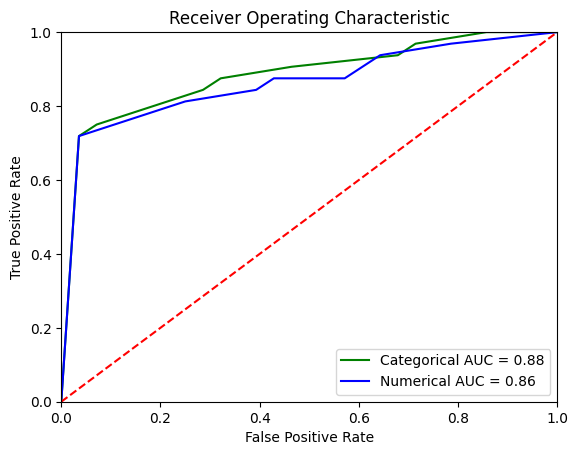

In [140]:
from matplotlib import pyplot as plt

f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cat, tpr_cat, 'g', label='Categorical AUC = %0.2f'%roc_auc_cat)
plt.plot(fpr_num, tpr_num, 'b', label='Numerical AUC = %0.2f'%roc_auc_num)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--') # Random classifier
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

\pagebreak
# Problem 2

(a) First we train the decision tree and generate its ROC curve based on the testing dataset:

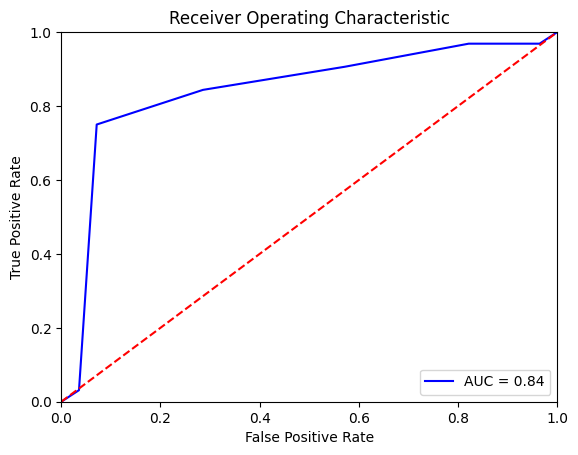

In [141]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
model = DecisionTreeClassifier()
model.fit(x_train, y_train);
prediction = model.predict_proba(x_test)

# Graph the ROC curve
fpr_tree, tpr_tree, _ = roc_curve(y_test, prediction[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_tree, tpr_tree, 'b', label='AUC = %0.2f'%roc_auc_tree)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--') # Random classifier
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

\pagebreak \
The visualization for the tree can be graphed as follow:

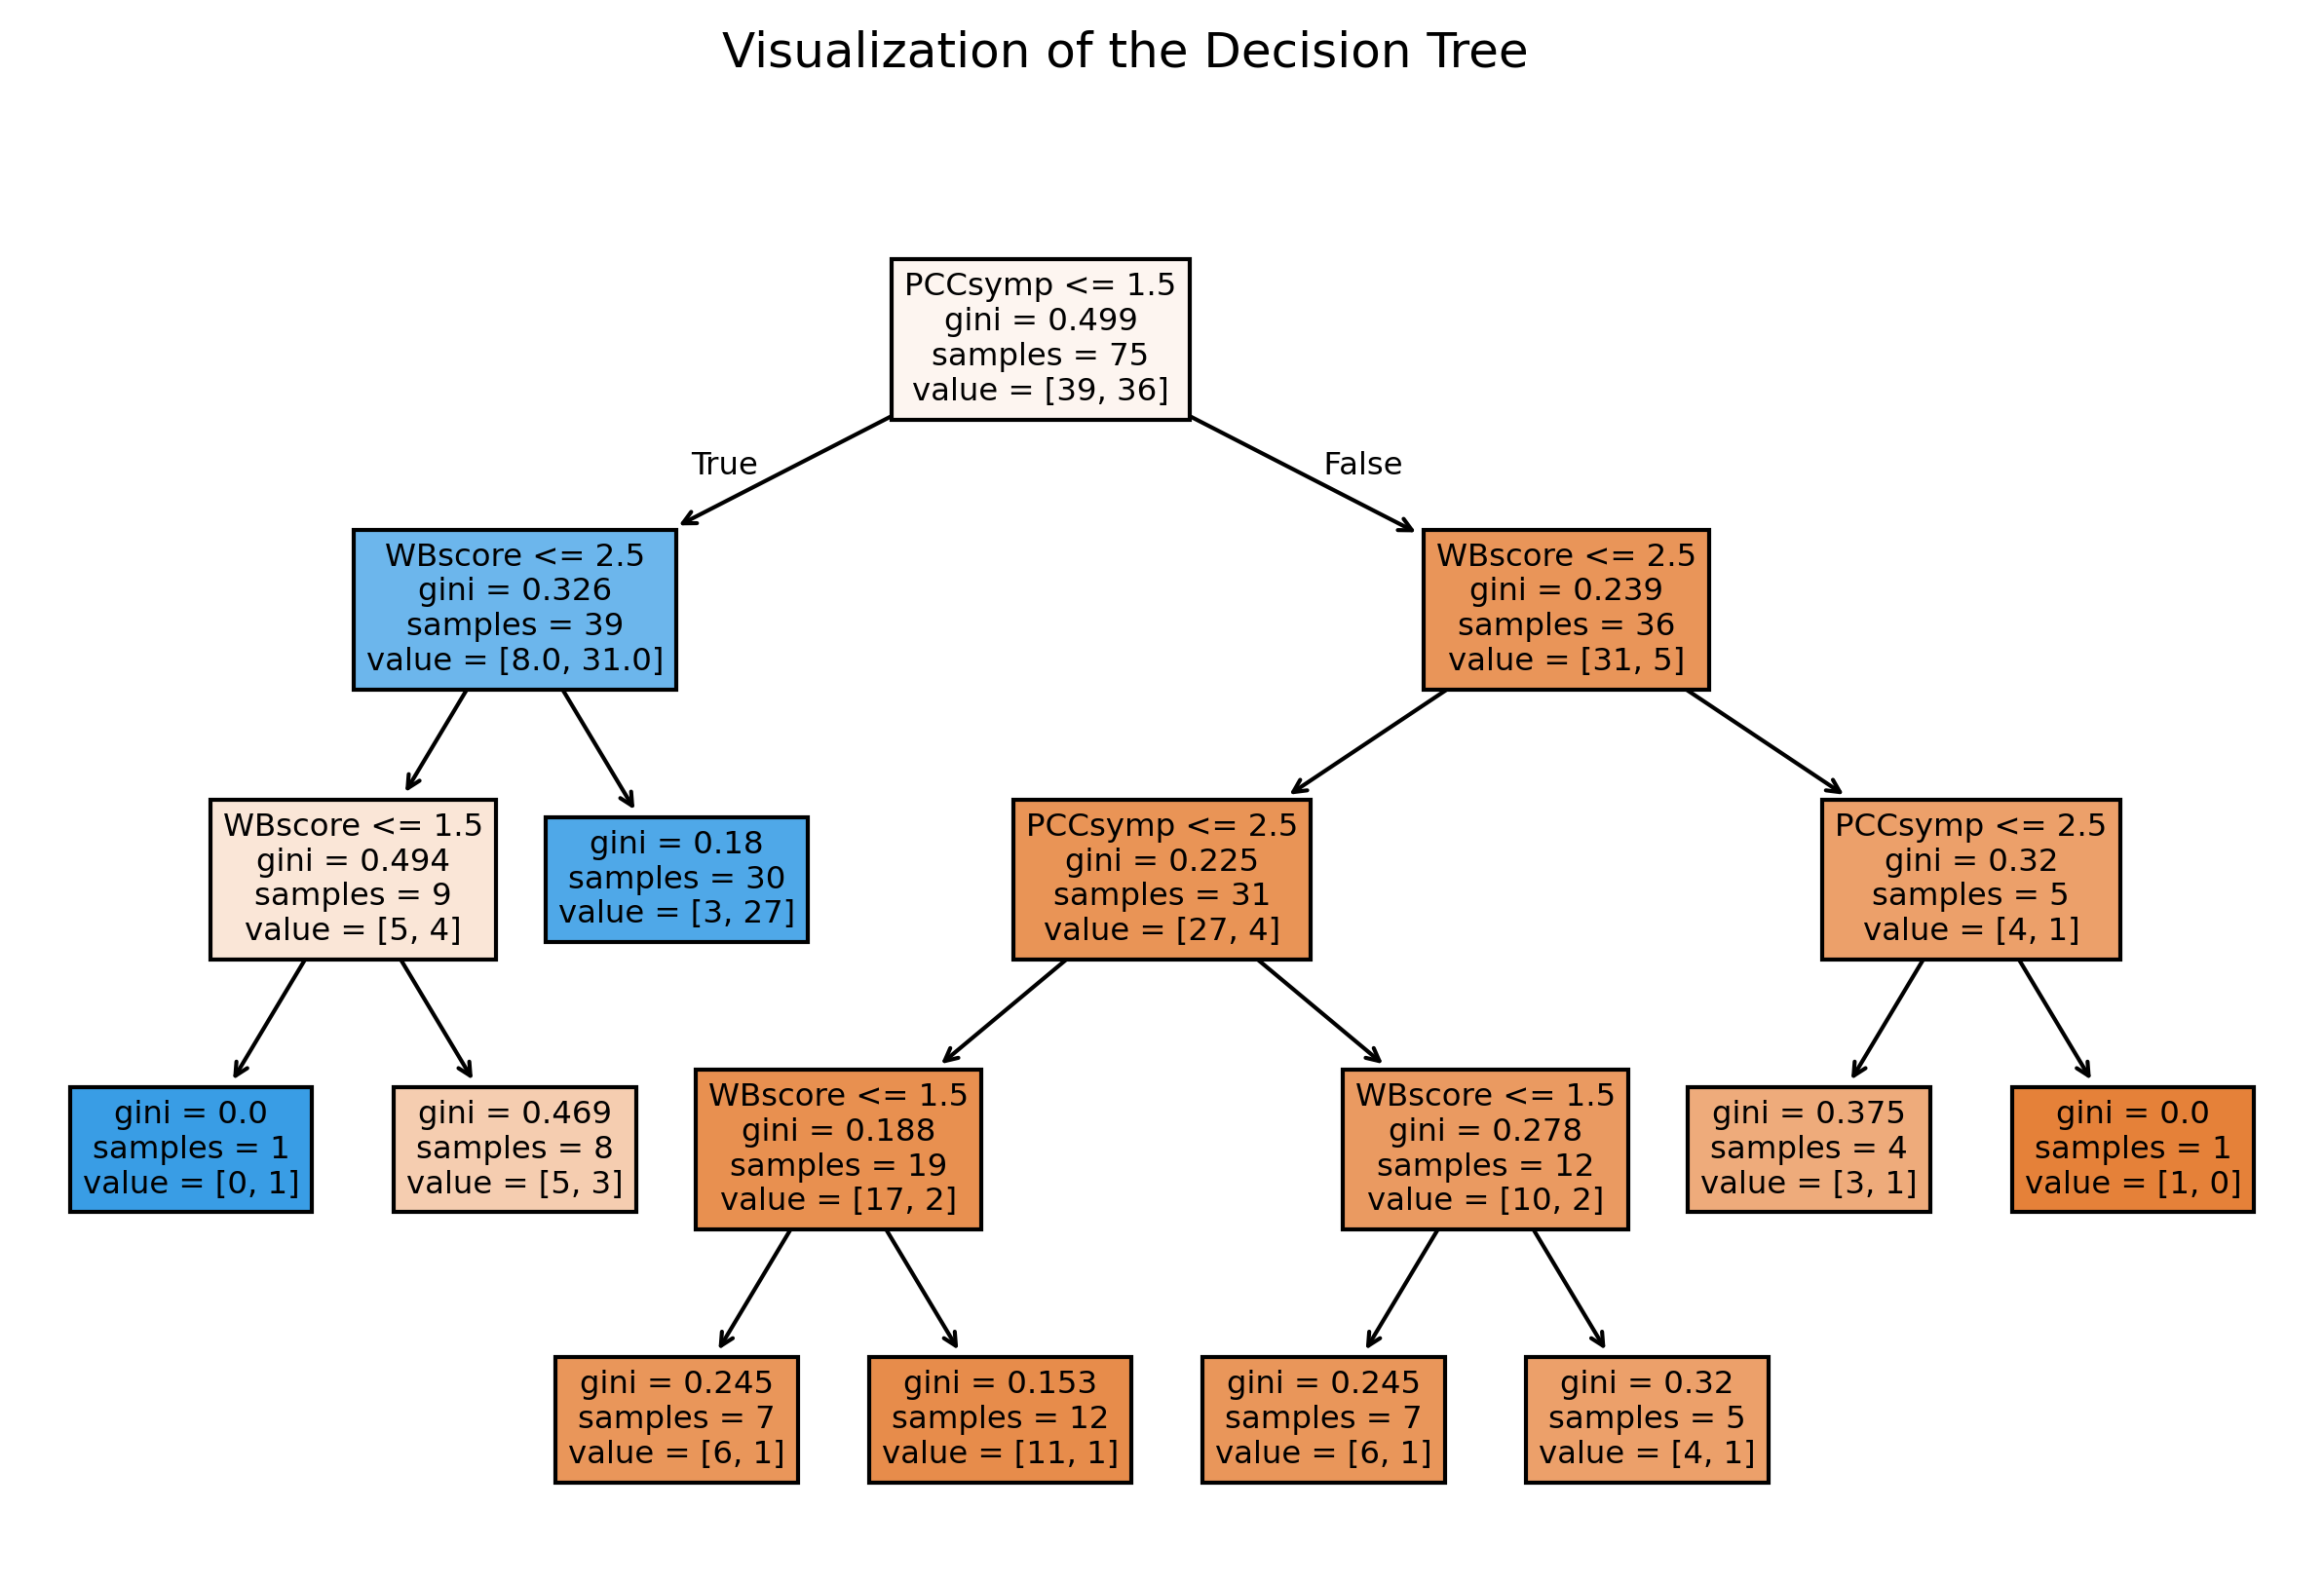

In [142]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,6), dpi=300)
plt.suptitle('Visualization of the Decision Tree')
tree.plot_tree(model, feature_names = ['WBscore', 'PCCsymp'], filled = True);

\pagebreak \
(b) Training a `CategoricalNB` model we arrive at the following ROC curve:

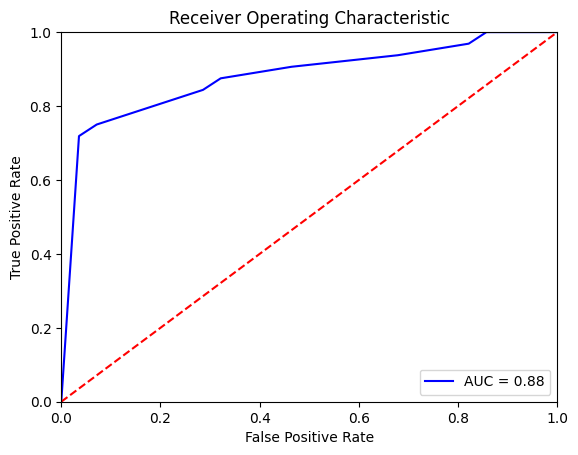

In [143]:
from sklearn.naive_bayes import CategoricalNB

# Train the model
model = CategoricalNB()
model = model.fit(x_train, y_train['vax_status'])
prediction = model.predict_proba(x_test)
fpr_NB, tpr_NB, _ = roc_curve(y_test, prediction[:,1])
roc_auc_NB = auc(fpr_NB, tpr_NB)

# Plot the ROC curve
f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_NB, tpr_NB, 'b', label='AUC = %0.2f'%roc_auc_NB)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--') # Random classifier
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

\pagebreak \
(c) Combining the three models' graphs we find out that logistic model performs the best, with the highest AUC.

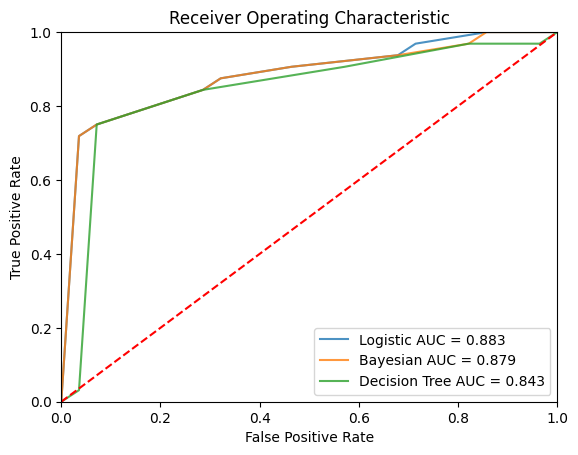

In [144]:
f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cat, tpr_cat, alpha=0.8, label='Logistic AUC = %0.3f'%roc_auc_cat)
plt.plot(fpr_NB, tpr_NB, alpha=0.8, label='Bayesian AUC = %0.3f'%roc_auc_NB)
plt.plot(fpr_tree, tpr_tree, alpha=0.8, label='Decision Tree AUC = %0.3f'%roc_auc_tree)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--') # Random classifier
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

\pagebreak
# Problem 3

(a) The predicted log odds of $y_i$ is
$$
\eta_i = \log(\frac{P(y_i)}{P(\text{not }y_i)}) = \log(\frac{\hat{p_i}}{1-\hat{p_i}})
$$

\pagebreak \
(b) Rearranging the abox equation we have
$$
\hat{p_i} = \frac{1}{1+e^{-\eta_i}}
$$

\pagebreak \
(c) Simplifying the above equation we have
$$
1-\hat{p_i} = \frac{e^{-\eta_i}}{1+e^{-\eta_i}}
$$

\pagebreak \
(d) Recall the definition of the log likelihood for one observaion is
$$
\begin{aligned}
\log {\cal L} &=  y_i \log \hat p_i \ + \ \left( 1-y_i \right) \log \left( 1 - \hat p_i \right)\\
&= y_i\log(\frac{1}{1+e^{-\eta_i}}) + (1-y_i)\log(\frac{e^{-\eta_i}}{1+e^{-\eta_i}})\\
&= y_i\cdot(0-\log(1+e^{-\eta_i})) + (1-y_i)\cdot (-\eta_i-\log(1+e^{-\eta_i}))\\
&= y_i\cdot \eta_i - \eta_i - \log(1+e^{-\eta_i})\\
&= y_i\cdot \eta_i - \eta_i - \log(\frac{e^{\eta_i}}{1+e^{\eta_i}})\\
&= y_i\cdot \eta_i - \log(1+e^{\eta_i})
\end{aligned} 
$$
Logistic regression assumes ${\eta_i}$ is a linear combination of $\{x_i\}$. Substituting this linear combination form of $\eta_i$ into the equation, we have reached the result of the proof.

\pagebreak \
(e) The cross entropy loss function is
$$
{\cal L}_\epsilon = -y_i \eta_i + \log(1+e^{\eta_i})
$$
Taking the derivative on both sides, we have
$$
\begin{aligned}
\frac{d {\cal L}_\epsilon}{d \eta_i} &= -y_i + \frac{1}{1+e^{\eta_i}}\cdot e^{\eta_i}\\
&= -y_i + \hat{p_i}\\
&= - (y_i - \hat{p_i})
\end{aligned}
$$
Which is the negative residual.

\pagebreak \
(f) Taking the second derivative and substituting $\eta_i$ with $\hat{p_i}$, we have

$$
\begin{aligned}
\frac{d^2 }{{d \eta_i}^2} {\cal L}_\epsilon &= 0 + (1+e^{-\eta_i})^{-1}\\
&= -(1+e^{-\eta_i})^{-2} \cdot e^{-\eta_i}\cdot (-1)\\
&= e^{-\eta_i} \cdot (1+e^{-\eta_i})^{-2}\\
&= e^{-\eta_i} \cdot e^{2\eta_i}\cdot (e^{\eta_i}\cdot (1+e^{-\eta_i}))^{-2}\\
&= e^{\eta_i}\cdot (e^{\eta_i}+1)^{-2}\\
&= \frac{\hat{p_i}}{1-\hat{p_i}}\cdot (\frac{\hat{p_i}}{1-\hat{p_i}}+1)^{-2}\\
&= \frac{\hat{p_i}}{1-\hat{p_i}} \cdot (1-\hat{p_i})^2\\
&= \hat{p_i}\cdot (1-\hat{p_i})
\end{aligned}
$$

\pagebreak
# Problem 4
(a) Calculating the partial derivatives we have
$$
\frac{\partial f}{\partial x} = 8x^3-2x \ \ \ \ \ \ \frac{\partial f}{\partial y} = 4y^3 - 6y
$$
Hence the gradient is
$$
\nabla f(x,y) = (\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}) = (8x^3-2x, 4y^3 - 6y)
$$

\pagebreak \
(b) The function required as well as two auxiliary functions can be found below.

In [145]:
def f(x,y):
    '''Returns the value of f at (x,y)'''
    return 2*x**4 + y**4 - x**2 -3*y**2 + 0.56

def gradient(x,y):
    '''Returns the gradient of f at (x,y)'''
    return np.array([8*x**3-2*x, 4*y**3-6*y], dtype='float')

def steps(start, step_size, k):
    '''Returns the first k step of gradient descent algorithm'''
    steps = np.empty([k,2])
    current = start.copy()
    updated = start.copy()
    for i in range(k):
        updated = current - step_size * gradient(*current)
        steps[i] = updated.copy()
        current = updated.copy()
    return steps

(c) Below is the code for the implementation

In [146]:
start = [2,4]
step_size = 0.01
k = 15

print('The optimization found minimum value {}'.format(
    np.round(f(*steps(start, step_size, k)[-1]), 5)
))

The optimization found minimum value -1.70262


(d) Below is the code for the implementation

In [147]:
start = [2,4]
step_size = 0.02
k = 15

print('The optimization found minimum value {}'.format(
    np.round(f(*steps(start, step_size, k)[-1]), 5)
))

The optimization found minimum value -1.79797


(e) Below is the code for the implementation

In [148]:
start = [-1,-1]
step_size = 0.01
k = 15

print('The optimization found minimum value {}'.format(
    np.round(f(*steps(start, step_size, k)[-1]), 5)
))

The optimization found minimum value -1.75043


\pagebreak \
(f) Based on the contour plot we realize function $f(x,y)$ has four local minima. Path C and D starts at the same point, but the first step of D is larger than the first step of C, and ends up landing in a different local minimum. Path E starts at an altogether different point, and hence lands in a third, different local minimum.

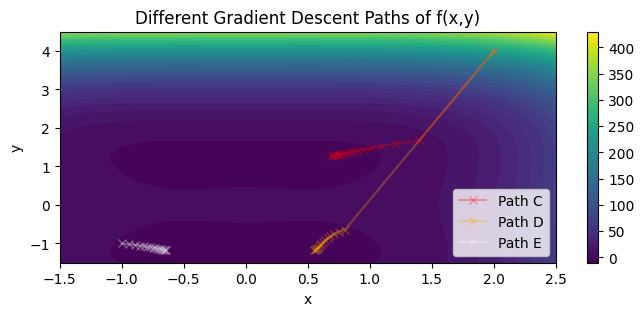

In [149]:
# Define the range for x and y
x_range = np.linspace(-1.5, 2.5, 400)
y_range = np.linspace(-1.5, 4.5, 400)
X, Y = np.meshgrid(x_range, y_range)
Z = f(X, Y)

# Plot the contour
fig = plt.figure(figsize=(8, 3))
cp = plt.contourf(X, Y, Z, levels=50)
plt.colorbar(cp)
plt.title('Different Gradient Descent Paths of f(x,y)')
plt.xlabel('x'); plt.ylabel('y')

# Plot path C
C_path = np.vstack([[2, 4], steps([2,4], 0.01, 15)])
plt.plot(C_path[:,0], C_path[:,1], label='Path C', marker='x', alpha=0.3, color='red')

# Plot path D
D_path = np.vstack([[2, 4], steps([2,4], 0.02, 15)])
plt.plot(D_path[:,0], D_path[:,1], label='Path D', marker='x', alpha=0.3, color='orange')

# Plot path E
E_path = np.vstack([[-1, -1], steps([-1,-1], 0.01, 15)])
plt.plot(E_path[:,0], E_path[:,1], label='Path E', marker='x', alpha=0.3, color='white')

plt.legend(loc='lower right')
plt.show()